### PCA Analyis and EOF plotting for daily  KE Adv and KE Gen (2017 Monsoon)

Explained variance (KE_ADV): [0.10090893 0.03547912 0.03131123 0.03024137 0.02649839 0.02202482
 0.02061219 0.01934301 0.01636279 0.01583493]
Explained variance (KE_GEN): [0.15180897 0.07737342 0.07221291 0.04599613 0.03728183 0.03258898
 0.03001342 0.02512526 0.02377048 0.02149736]


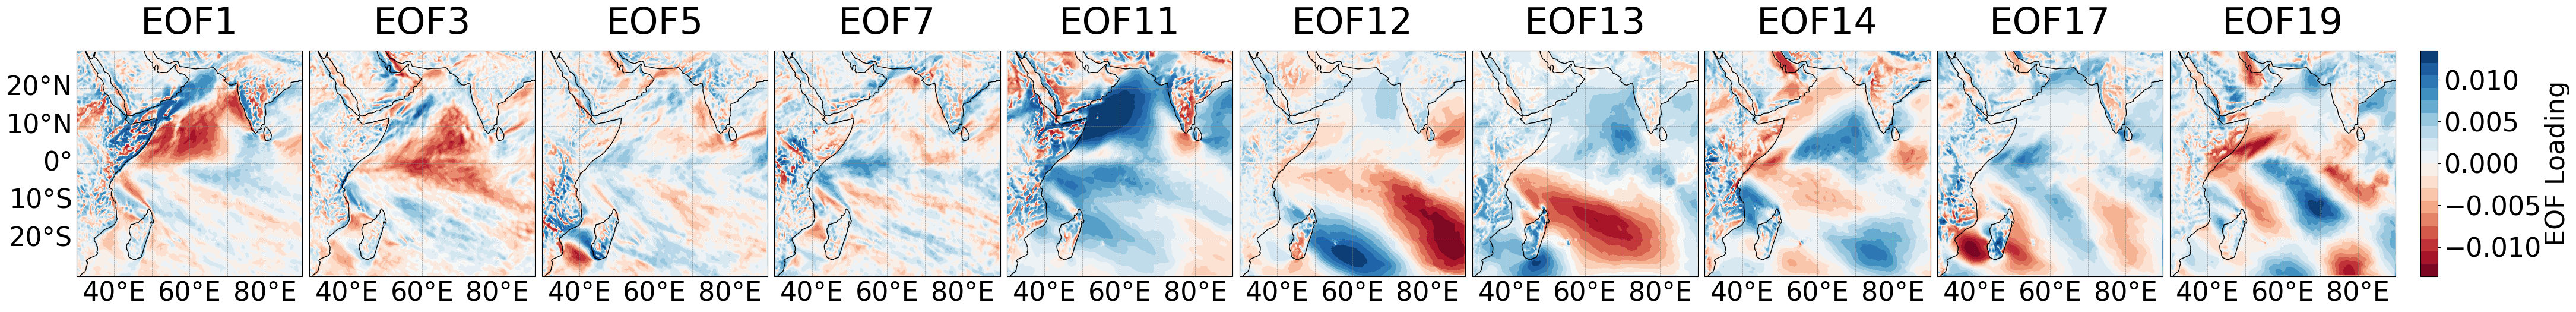

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator

# ====================================================
# 1. COMMON FUNCTION TO COMPUTE EOF MAPS
# ====================================================
def compute_eofs(df, value_col, lat_range=(-30, 30), lon_range=(30, 90), n_components=10):
    df = df.copy()
    df['valid_time'] = pd.to_datetime(df['valid_time'])

    # Filter for monsoon region + months
    df = df[
        (df['valid_time'].dt.month >= 5) &
        (df['valid_time'].dt.month <= 10) &
        (df['latitude'].between(*lat_range)) &
        (df['longitude'].between(*lon_range))
    ]

    # Create pivot (time × spatial grid)
    pivot_df = df.pivot_table(index='valid_time',
                              columns=['latitude', 'longitude'],
                              values=value_col)
    pivot_df = pivot_df.dropna(axis=0, how='any')

    # Standardize + PCA
    scaler = StandardScaler()
    X_std = scaler.fit_transform(pivot_df.values)

    pca = PCA(n_components=n_components)
    PC_scores = pca.fit_transform(X_std)
    EOFs = pca.components_

    # Reshape EOFs
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())
    n_lat, n_lon = len(lat_vals), len(lon_vals)

    EOF_maps = {
        f"EOF{i+1}": EOFs[i, :].reshape(n_lat, n_lon)
        for i in range(n_components)
    }

    return EOF_maps, lat_vals, lon_vals, pca.explained_variance_ratio_


# ====================================================
# 2. LOAD DATA
# ====================================================
ke_adv_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/india_country/2017_ke_adv_daily.parquet')
ke_gen_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/india_country/2017_ke_gen_daily.parquet')

# ====================================================
# 3. COMPUTE EOFs FOR BOTH
# ====================================================
EOF_adv, lat_vals, lon_vals, var_adv = compute_eofs(ke_adv_df, 'ke_advection')
EOF_gen, _, _, var_gen = compute_eofs(ke_gen_df, 'ke_gen')

print("Explained variance (KE_ADV):", var_adv[:10])
print("Explained variance (KE_GEN):", var_gen[:10])

# ====================================================
# 4. SIGN FLIPS & EOF SELECTION
# ====================================================
flip_adv = ['EOF7']
flip_gen = ['EOF7', 'EOF2', 'EOF3']

selected_adv = ['EOF1', 'EOF3', 'EOF5', 'EOF7']
selected_gen = ['EOF1', 'EOF2', 'EOF3', 'EOF4', 'EOF7', 'EOF9']

# ====================================================
# 5. SETUP GRID FOR PLOTTING
# ====================================================
lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)
total_plots = len(selected_adv) + len(selected_gen)

# ====================================================
# 6. CREATE FIGURE
# ====================================================
fig, axs = plt.subplots(
    1, total_plots,
    figsize=(3 * total_plots + 12, 20),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
plt.subplots_adjust(wspace=0.03, left=0.02, right=0.95)

# ====================================================
# 7. PLOT ALL EOFs IN ONE LOOP
# ====================================================
for i, key in enumerate(selected_adv + selected_gen):

    # Choose the right dataset + flip signs
    if i < len(selected_adv):
        eof_map = -EOF_adv[key] if key in flip_adv else EOF_adv[key]
        eof_num = int(key.replace('EOF', ''))
    else:
        eof_map = -EOF_gen[key] if key in flip_gen else EOF_gen[key]
        eof_num = int(key.replace('EOF', '')) + 10

    cs = axs[i].contourf(
        lon_mesh, lat_mesh, eof_map,
        levels=20, cmap='RdBu',
        transform=ccrs.PlateCarree()
    )

    axs[i].coastlines()
    axs[i].set_extent(
        [lon_vals.min(), lon_vals.max(),
         lat_vals.min(), lat_vals.max()],
        crs=ccrs.PlateCarree()
    )

    gl = axs[i].gridlines(draw_labels=True, linewidth=0.5,
                          color='gray', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True if i == 0 else False
    gl.xlabel_style = {'size': 32}
    gl.ylabel_style = {'size': 32}

    axs[i].set_title(f'EOF{eof_num}', fontsize=45, pad=20)


# ====================================================
# 8. MANUAL COLORBAR (ALIGNED TO RIGHT)
# ====================================================
pos = axs[-1].get_position()
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.007, pos.height])

cbar = fig.colorbar(cs, cax=cax, orientation='vertical')
cbar.set_label('EOF Loading', fontsize=32)
cbar.ax.tick_params(labelsize=32)

cbar.locator = MaxNLocator(nbins=6)
cbar.update_ticks()

plt.show()
